In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from moleculeGeneration import *

In [2]:
num_of_atoms = 20
basic_mols = [generateMoleculePart(100*i,num_of_atoms) for i in range(20)]
advanced_mols = [generateMoleculePart(10000*i,num_of_atoms) for i in range(20)]

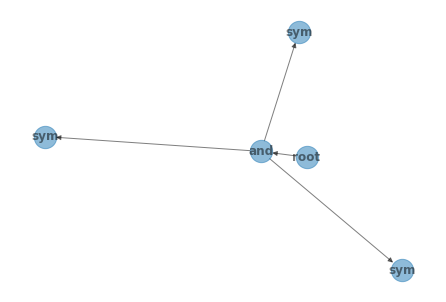

In [3]:
G = advanced_mols[3][1]
labels = nx.get_node_attributes(G, 'type') 
nx.draw(G, labels=labels,
        node_size=500, alpha=0.5, font_weight="bold", arrows=True)

[None, None, None]


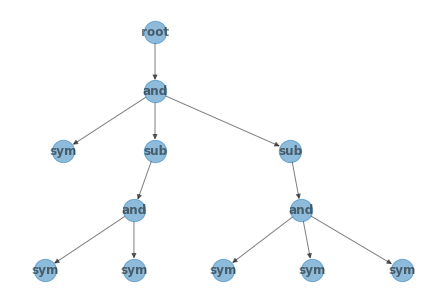

In [4]:
params,G = generateMolecule(advanced_mols,basic_mols)
pos = graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'type') 
nx.draw(G, pos=pos, labels=labels,
    node_size=500, alpha=0.5, font_weight="bold", arrows=True)
print(params)

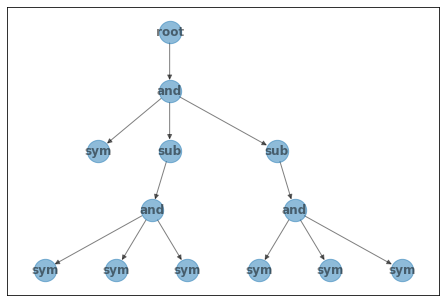

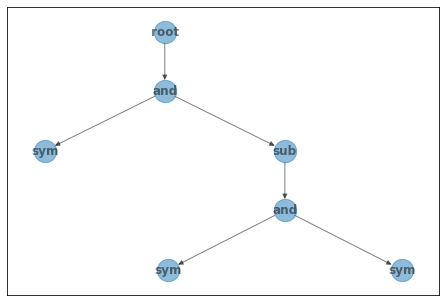

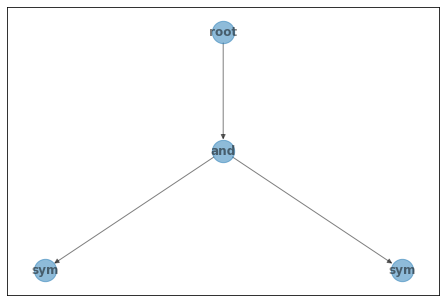

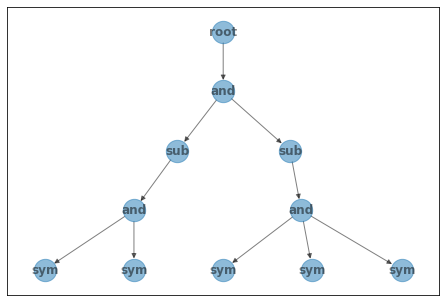

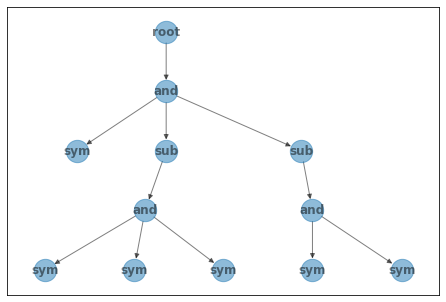

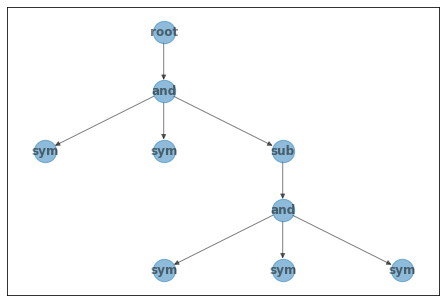

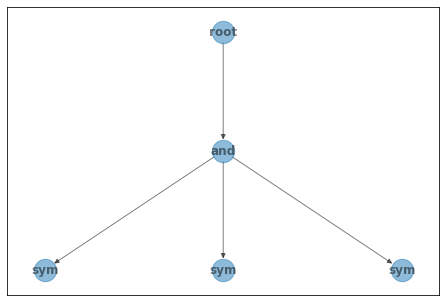

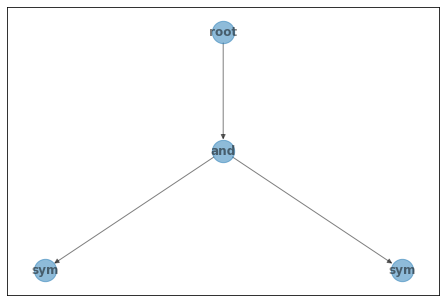

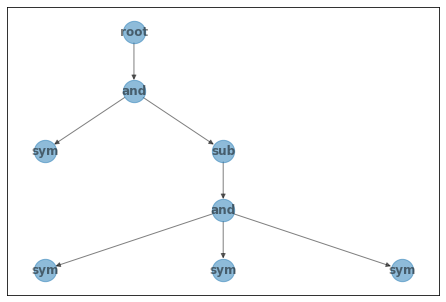

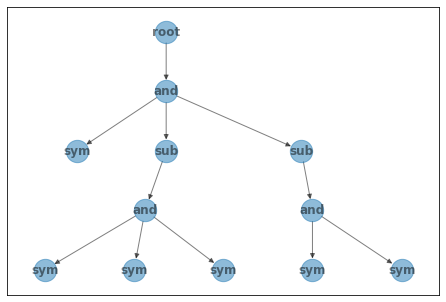

In [5]:
for i in range(10):
    params,G = generateMolecule(advanced_mols,basic_mols)
    pos = graphviz_layout(G, prog="dot")
    labels = nx.get_node_attributes(G, 'type') 
    nx.draw(G, pos=pos, labels=labels,
        node_size=500, alpha=0.5, font_weight="bold", arrows=True)
    plt.axis('on')
    plt.show()

In [6]:
mols = {i:generateMolecule(advanced_mols,basic_mols) for i in range(50)}
instancesData = [generateInstanceData(mols) for i in range(500)]

In [7]:
instance = instancesData[4]
get_splited_molecules(instance)

{0: {'comps': [['17'], ['0']], 'doorTo': None},
 1: {'comps': [['15', '8', '19', '13', '19', '8', '7'], ['7']], 'doorTo': 0},
 2: {'comps': [['13', '8']], 'doorTo': 1}}

In [8]:
pointers,blocks = get_blocks(instance)   

In [18]:
def get_molecule_ids(instance):
    return [i['molecule_ix'] for i in instance]

[5, 44, 2]

In [27]:
def merge_parents(G,parents,node):
    data = []
    for p in parents:
        data.append(G.nodes(data=True)[p]['data'])
        G.remove_node(p)
    G.add_node(p,data=flatten(data))
    succs = list(G.successors(node))
    G = split_node(G,node,p)
    assert len(succs)<2
    if len(succs)==1: 
        G.add_edge(node,succs[0])
    return G

def get_block_graph(merged_blocks,mol_ids):
    G = nx.DiGraph()
    edges = []
    for k,v in merged_blocks.items():
        if type(v)==dict:
            for k_,v_ in v.items():
                edges.append(((k_,k),mol_ids[k_]))
        G.add_node(k,data=v)
    for e,v in edges:
        G.add_edge(*e,obstacle_id=v)

    nodes_to_split = []

    for v in G.nodes():
        if len(G.in_edges(v))>1:
            nodes_to_split.append(v)
    for v in sorted(nodes_to_split):
        parents = list(G.predecessors(v))
        G = merge_parents(G,parents,v)
    return G, nodes_to_split

def get_merged_blocks(blocks):
    atoms_in_blocks = defaultdict(list)
    for k,v in blocks.items():
        locked = blocks[k][1]
        if locked == None:
            atoms_in_blocks[k].append(blocks[k][0])
        else:
            atoms_in_blocks[k].append(locked)
            atoms_in_blocks[list(locked.keys())[0]].append(blocks[k][0])

    merged_blocks = {}
    for k,v in atoms_in_blocks.items():
        merged_blocks[k]=merge_block(v)
    return merged_blocks

In [28]:
merged_blocks

{2: ['13', '8', '7'],
 1: {2: ['15', '8', '19', '13', '19', '8', '7', '0']},
 0: {1: ['17']}}

In [29]:
mol_ids = get_molecule_ids(instance)


In [219]:
mol_ids

[5, 44, 2]

In [31]:
merged_blocks = get_merged_blocks(blocks)

In [213]:
G,nodes_to_split = get_block_graph(merged_blocks,mol_ids)

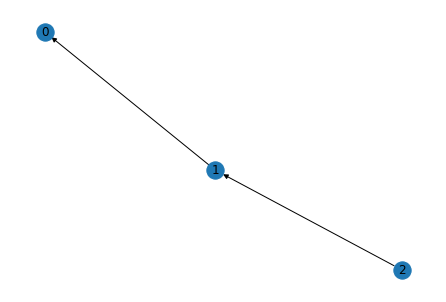

In [214]:
nx.draw(G,with_labels = True)

In [34]:
G.nodes(data=True)

NodeDataView({2: {'data': ['13', '8', '7']}, 1: {'data': {2: ['15', '8', '19', '13', '19', '8', '7', '0']}}, 0: {'data': {1: ['17']}}})

In [105]:
rnd.randint(0,0)

0

In [215]:
def split_to_rooms(lst):
    max_ = min(len(lst)-1,3)
    min_ = min((len(lst)-1)//3,3)
    num_splits = rnd.randint(min_,max_)
    possible = list(range(1,len(lst)))
    splits = sorted(rnd.sample(possible,num_splits))
    chunks = []
    start = 0
    end = 0
    for end in splits:
        chunks.append(lst[start:end])
        start = end
    chunks.append(lst[end:])
    return chunks
for node in G.nodes(data=True):
    data = node[1]['data']
    if type(data) != list:
        data = list(data.values())[0]
    data = split_to_rooms(data)
    G.nodes[node[0]]['data']=data

In [216]:
G.nodes(data=True)

NodeDataView({2: {'data': [['13'], ['8', '7']]}, 1: {'data': [['15'], ['8', '19', '13'], ['19', '8', '7', '0']]}, 0: {'data': [['17']]}})

In [207]:
instance

[{'obstacle_G_ix': None,
  'edge': None,
  'params': [None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x7f499a984ad0>,
  'molecule_ix': 5},
 {'obstacle_G_ix': 0,
  'edge': (40001, 40003),
  'params': [None, None, None, None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x7f4a30c47810>,
  'molecule_ix': 44},
 {'obstacle_G_ix': 1,
  'edge': ('gh101', 'gh102'),
  'params': [None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x7f499a979890>,
  'molecule_ix': 2}]

In [218]:
import pickle
with open('testGraph.pkl', 'wb') as f:
    pickle.dump({'layout_spec':G,'molecules':instance},f)

In [217]:
G.edges(data=True)

OutEdgeDataView([(2, 1, {'obstacle_id': 2}), (1, 0, {'obstacle_id': 44})])

In [25]:
for i in range(len(instance)):
    print(collect_symbols(instance[i]['molecule']))

[['7', '0', '16', '9', '7']]
[['12', '2', '10']]


In [231]:
for i in range(len(merged_blocks)):
    merged_blocks[i] 

[{'obstacle_G_ix': None,
  'edge': None,
  'params': [None, None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x7f3050dead50>,
  'molecule_ix': 48},
 {'obstacle_G_ix': 0,
  'edge': ('h1701', 'h1703'),
  'params': [None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x7f304d80abd0>,
  'molecule_ix': 6},
 {'obstacle_G_ix': 1,
  'edge': (90001, 90003),
  'params': [None, None],
  'molecule': <networkx.classes.digraph.DiGraph at 0x7f30d5305210>,
  'molecule_ix': 15}]

In [96]:
mols[12][1].nodes(data=True)

NodeDataView({'g150000': {'type': 'root', 'label': '150000'}, 'g150001': {'type': 'and', 'label': 'and'}, 'g150003': {'type': 'sym', 'label': '15'}, 'g150004': {'type': 'sym', 'label': '0'}, 'h900': {'type': 'sub', 'label': '900'}, 'h901': {'type': 'and', 'label': 'and'}, 'h902': {'type': 'sym', 'label': '4'}, 'h903': {'type': 'sym', 'label': '11'}, 'h904': {'type': 'sym', 'label': '7'}})

In [2]:
def generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used):
    num_ands = rnd.randint(2,3)
    G.add_node(last_ix+1,type='or',label='or')
    G.add_edge(pointer,last_ix+1)
    last_ix += 1
    pointer = last_ix
    for i in range(num_ands):
        last_ix,G = generateAnd(G,n_sym,last_ix,pointer,level,parameter,parameter_used,disj_used=True)
    return last_ix,G

def generateAnd(G,n_sym,last_ix,pointer,level,parameter=None,parameter_used=True,disj_used=False):
    disj = rnd.random() < 0.2 and not disj_used
    # generate Or node
    if disj:
        last_ix,G=generateOr(G,n_sym,last_ix,pointer,level,parameter,parameter_used)     
    # generate And node
    else:
        G.add_node(last_ix+1,type='and',label='and')
        G.add_edge(pointer,last_ix+1)
        last_ix += 1
        pointer = last_ix
        num_syms = rnd.randint(2,3)
        # generate And descendants
        for i in range(num_syms):
            subgoal= rnd.random() < 0.2 and level < 1
            # generate subtree
            if subgoal:
                G.add_node(last_ix+1,type='sub',label=str(last_ix + 1))
                G.add_edge(pointer,last_ix+1)    
                last_ix,G = generateAnd(G,n_sym,last_ix+1,last_ix+1,level+1,parameter,parameter_used,disj_used=False)
            # generate leafs
            else:
                # first leaf should be parameter if the molecule is parametrized
                if not parameter_used:
                    G.add_node(last_ix+1,type='par',label=str(parameter))                    
                    G.add_edge(pointer,last_ix+1) 
                # normal symbol
                else:
                    sym = rnd.randint(0,n_sym)
                    in_par = sym  // 5 == parameter
                    # the symbol may be sampled from the range of the parameter
                    if in_par:
                        G.add_node(last_ix+1,type='par',label=str(parameter))
                    else: G.add_node(last_ix+1,type='sym',label=str(sym))                    
                    G.add_edge(pointer,last_ix+1) 
                last_ix += 1
            parameter_used = True
    return last_ix, G
        

def generateMolecule():
    # some molecules will be parametrized
    parametrized = rnd.random() < 0.2
    G = nx.DiGraph()
    last_ix = 21
    pointer = last_ix
    # root of the molecule
    G.add_node(last_ix,type='root')
    parameter = None
    if parametrized:
        # there are 5 types of parameters
        parameter = rnd.randint(0,4)
        ix,graph = generateAnd(G,20,last_ix,pointer,1,parameter,False)
    else:
        ix,graph = generateAnd(G,20,last_ix,pointer,1)
    return graph, parameter
    

In [ ]:
#ix,G,parameter = generateMolecule(1)
pos = graphviz_layout(G, prog="dot")
labels = nx.get_node_attributes(G, 'type') 
nx.draw(, pos=pos, with_labels=True,#labels=labels,
    node_size=500, alpha=0.5, font_weight="bold", arrows=True)
plt.axis('on')
plt.show()

In [ ]:
G_dict = {}
for x in range (0,30):
    G_dict[x]=nx.DiGraph()

In [ ]:
# atoms
def add_random_atoms(G_dict_param):
    and_node = "and"
    goal_node = "goal"
    for j in range(len(G_dict_param)):

        rnd_number1_group1 = rnd.randint(1, 5)

        G_dict_param[j].add_node(rnd_number1_group1, group=1)
        G_dict_param[j].add_node(and_node, type=1)
        G_dict_param[j].add_node(goal_node, type=3)
        G_dict_param[j].add_edge(rnd_number1_group1, and_node)
        G_dict_param[j].add_edge(and_node, goal_node)
        for k in range(rnd.randrange(1,5)):
            rnd_number2_group1 = rnd.randint(1, 5)
            G_dict_param[j].add_node(rnd_number2_group1)
            G_dict_param[j].add_edge(rnd_number2_group1, and_node)
    return G_dict_param

def create_new(n):
    and_node_1 = "and_1"
    and_node_2 = "and_2"
    and_nodes = [and_node_1, and_node_2]
    or_node = "or"
    goal_node = "goal"
    node_lst_to_connect = {}

    G_dict[n] = nx.DiGraph()

    G_dict[n].add_node(or_node, type=2)
    G_dict[n].add_node(and_node_1, type=1)
    G_dict[n].add_node(and_node_2, type=1)
    G_dict[n].add_node(goal_node, type=3)

    G_dict[n].add_edge(and_node_1, or_node)
    G_dict[n].add_edge(and_node_2, or_node)
    G_dict[n].add_edge(or_node, goal_node)
    counter=0
    counter2=0

    while len(G_dict[n].in_edges(and_node_1)) < rnd.randint(2,3):
        rnd_number1_group1 = rnd.randint(1, 5)
        G_dict[n].add_node(rnd_number1_group1, group=1)
        node_lst_to_connect[counter] = rnd_number1_group1
        node_to_add_1 = node_lst_to_connect.get(counter)
        counter += 1
        G_dict[n].add_edge(node_to_add_1, and_node_1)

    while len(G_dict[n].in_edges(and_node_2)) < rnd.randint(2,3):
        rnd_number2_group1 = rnd.randint(1, 5)
        G_dict[n].add_node(rnd_number2_group1, group=1)
        node_lst_to_connect[counter] = rnd_number2_group1
        node_to_add_1 = node_lst_to_connect.get(counter)
        counter2 += 1
        G_dict[n].add_edge(node_to_add_1, and_node_2)

    return G_dict[n]

def check_if_2_same_graphs_and_remove():
    for k in range(len(G_dict)):
        for j in range(len(G_dict)):
            if G_dict[k].nodes == G_dict[j].nodes and k != j:
                    del G_dict[j]
                    G_dict[j] = create_new(j)

In [ ]:
G_dict = add_random_atoms(G_dict)
check_if_2_same_graphs_and_remove()

In [ ]:
for i in range(len(G_dict)):
    nx.draw(G_dict[i], with_labels=True,
        node_size=1500, alpha=0.5, font_weight="bold", arrows=True,
        connectionstyle='arc3, rad = 0.1')
    print(i)
    plt.axis('on')
    plt.show()

0


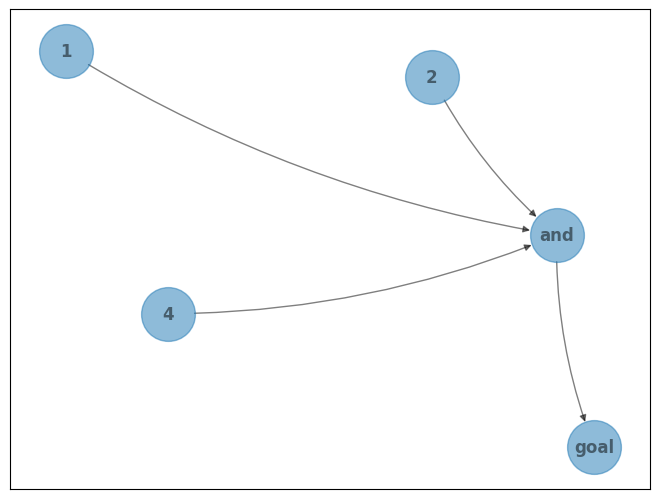

1


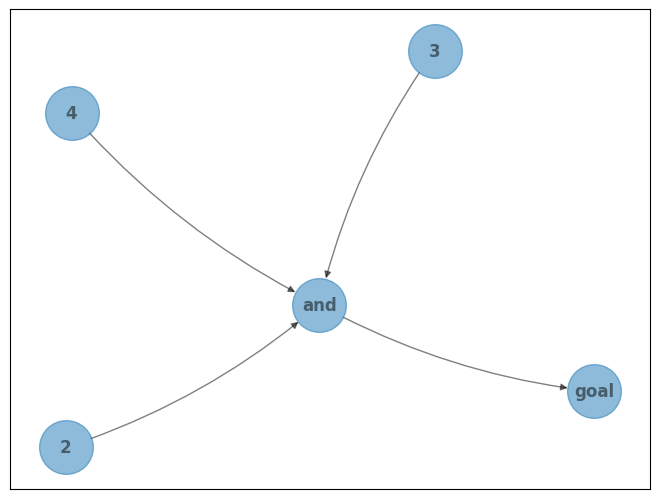

2


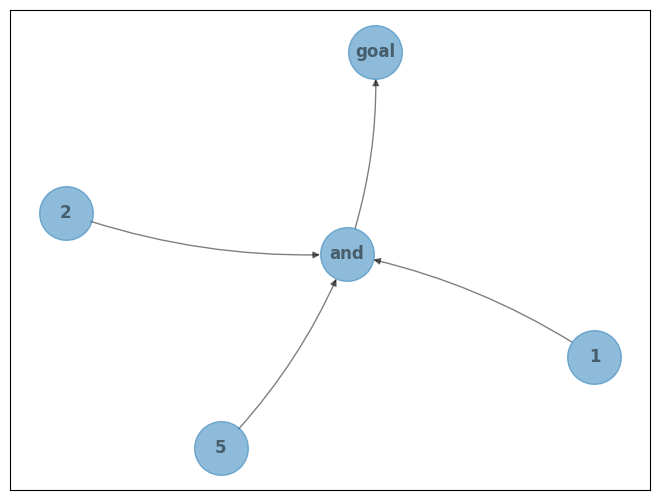

3


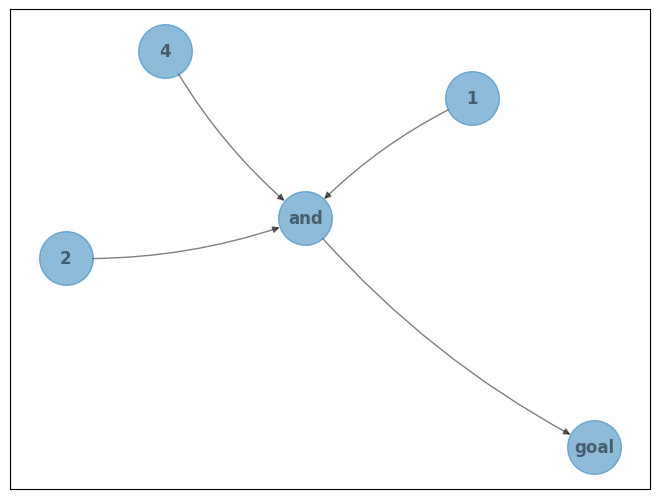

4


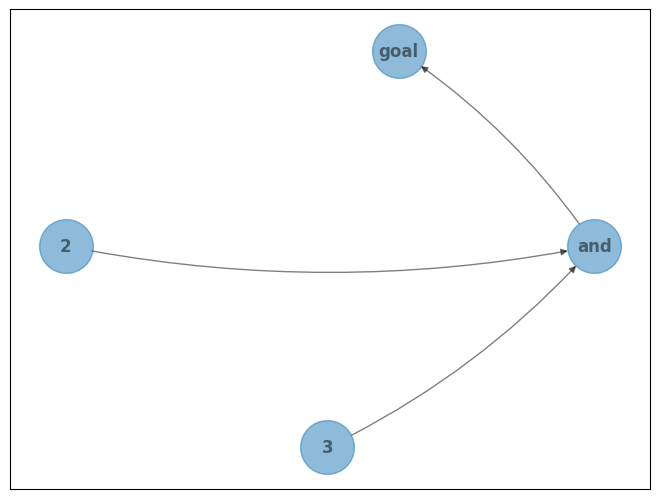

5


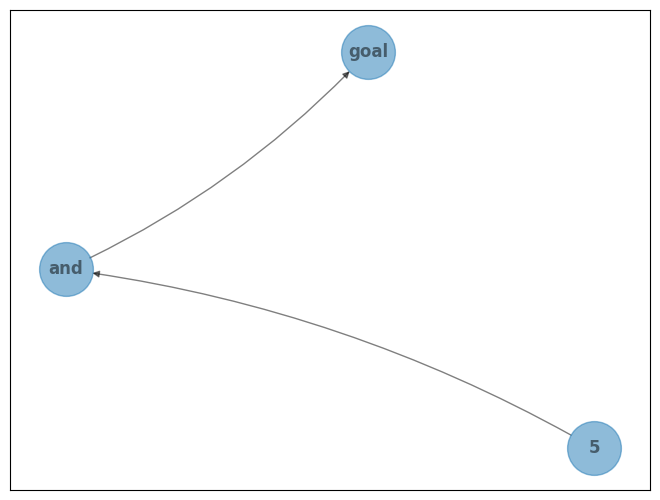

6


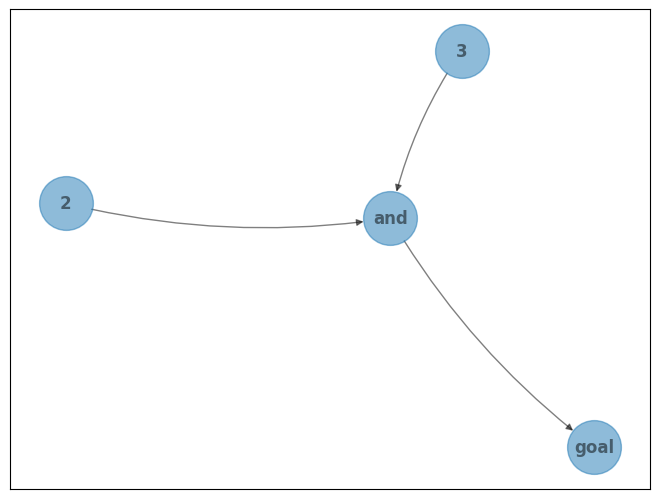

7


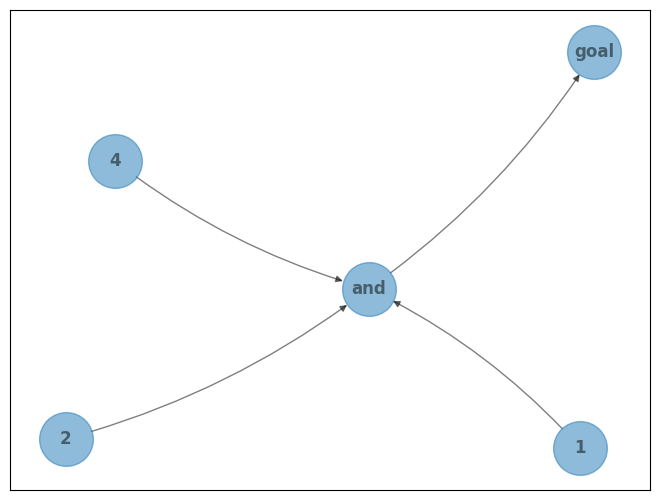

8


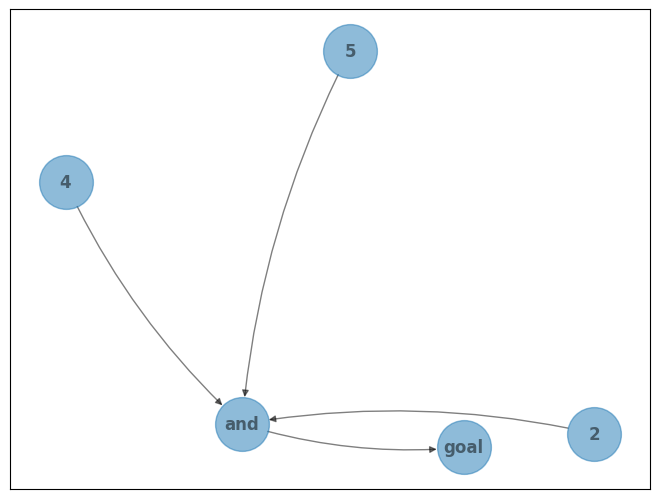

9


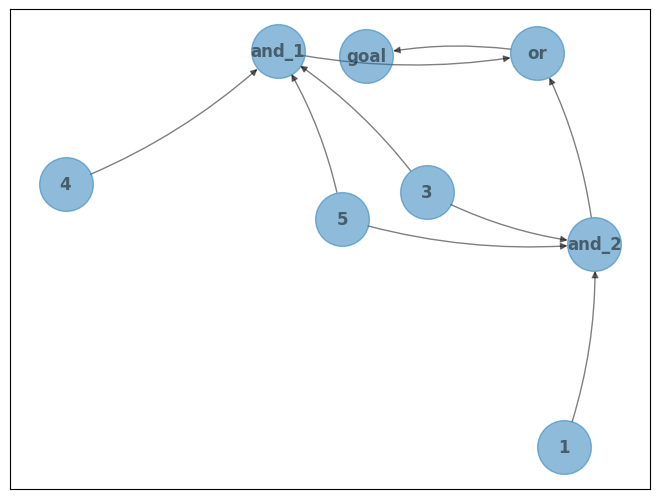

10


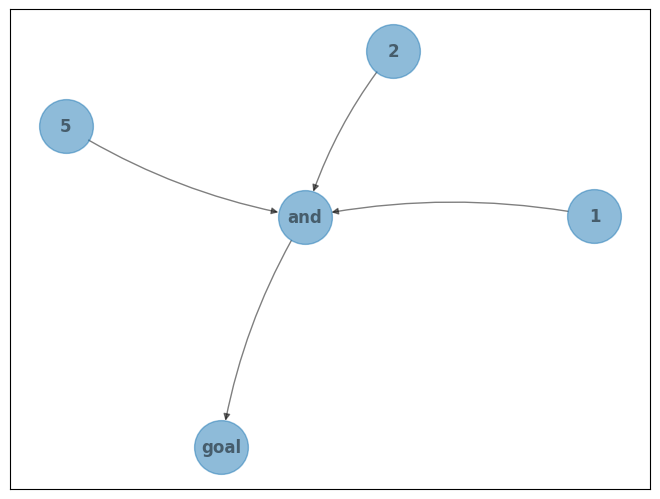

11


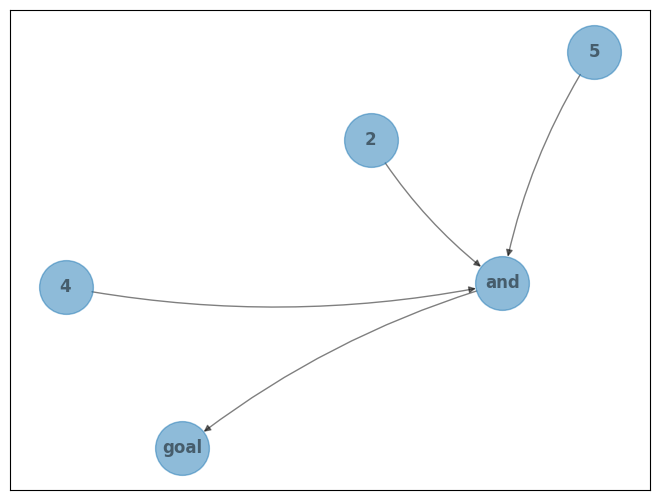

12


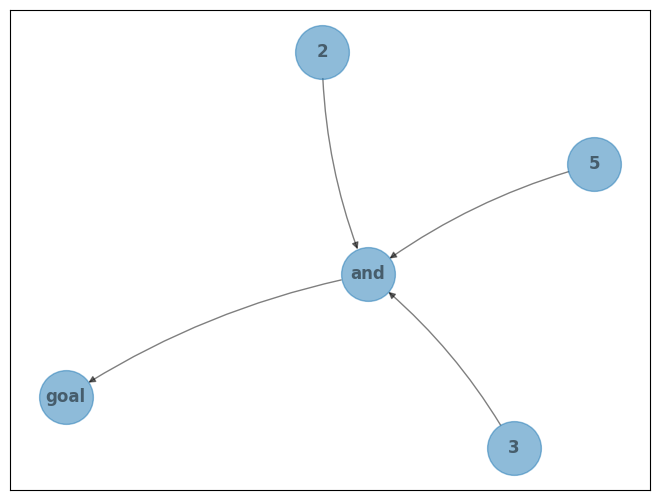

13


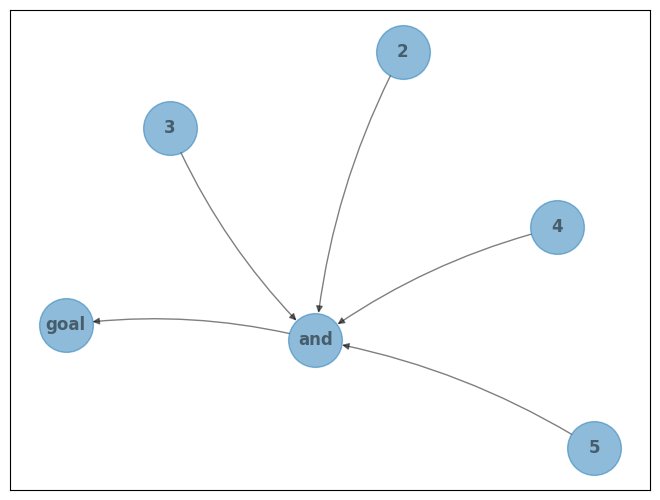

14


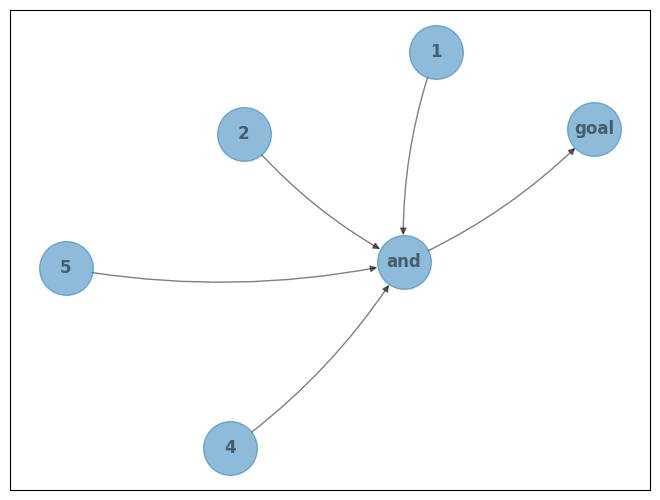

15


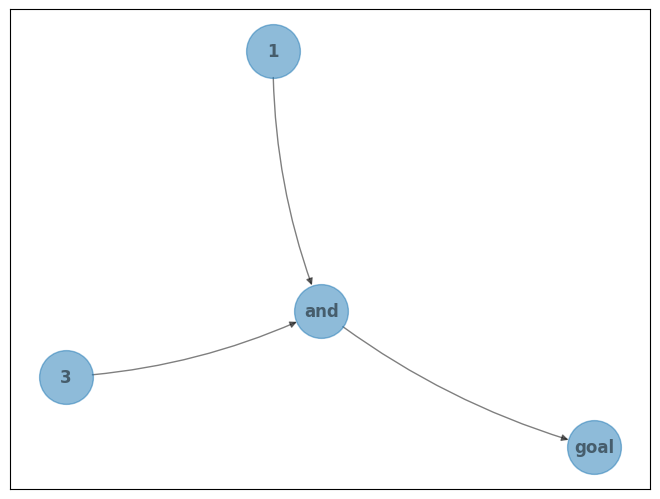

16


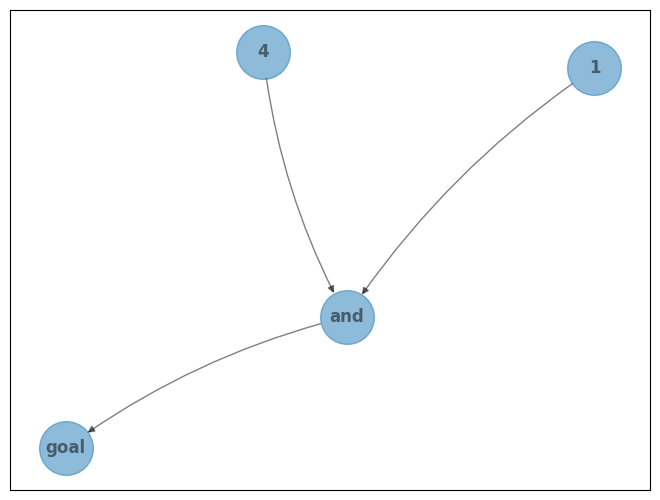

17


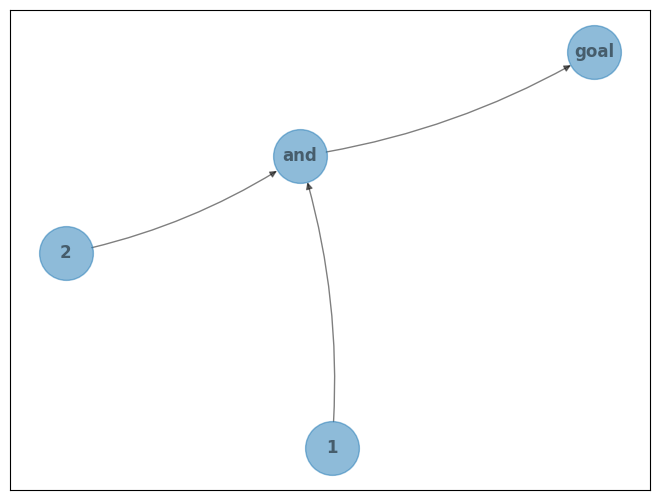

18


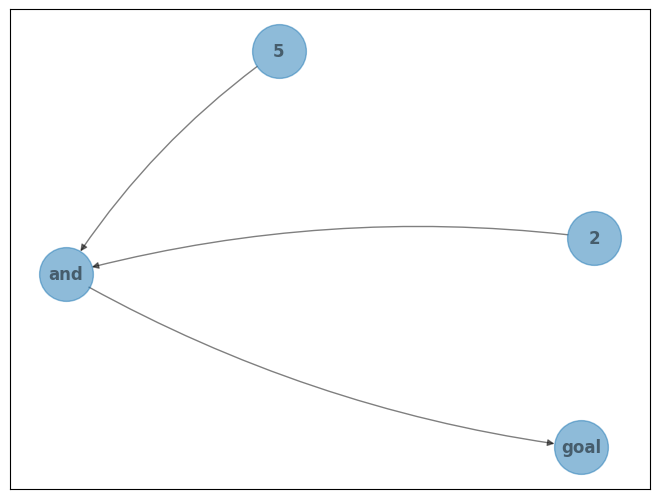

19


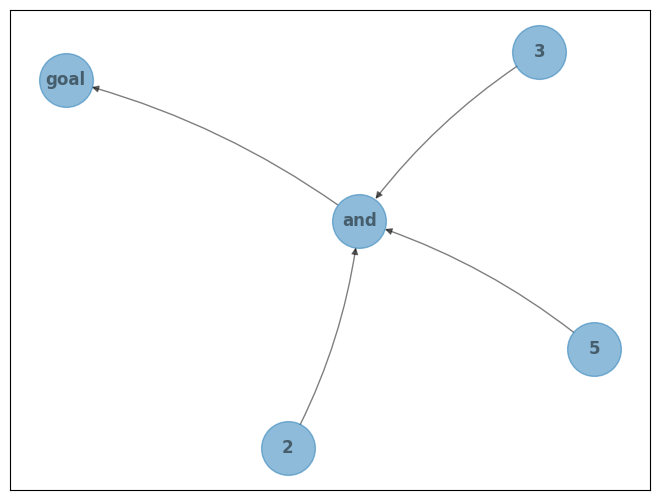

20


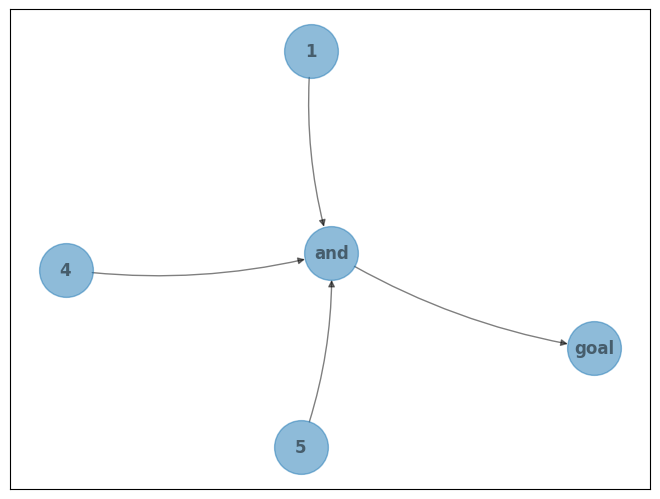

21


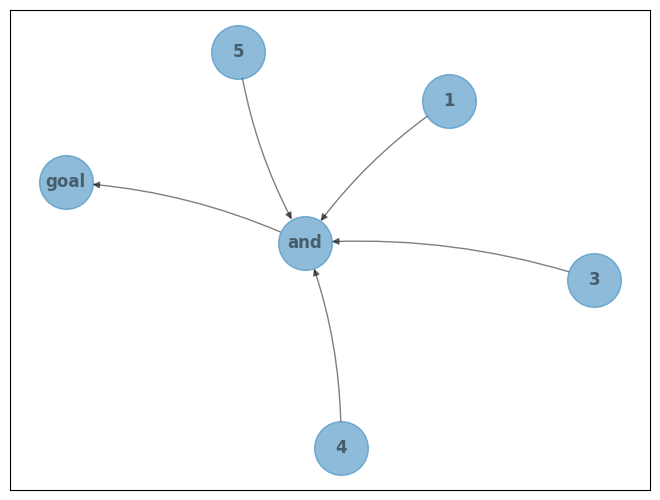

22


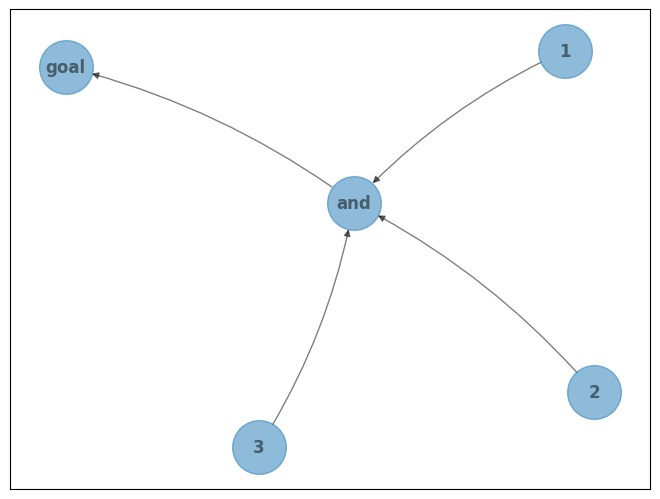

23


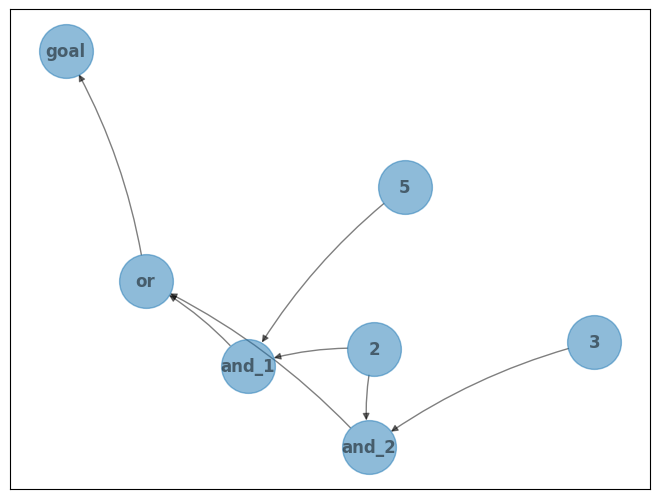

24


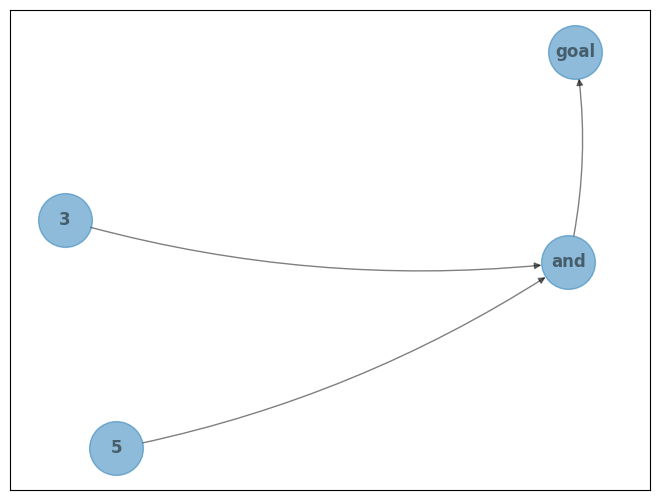

25


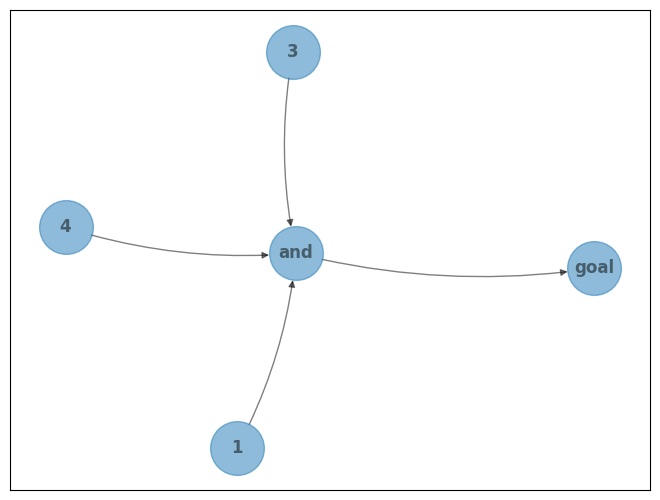

26


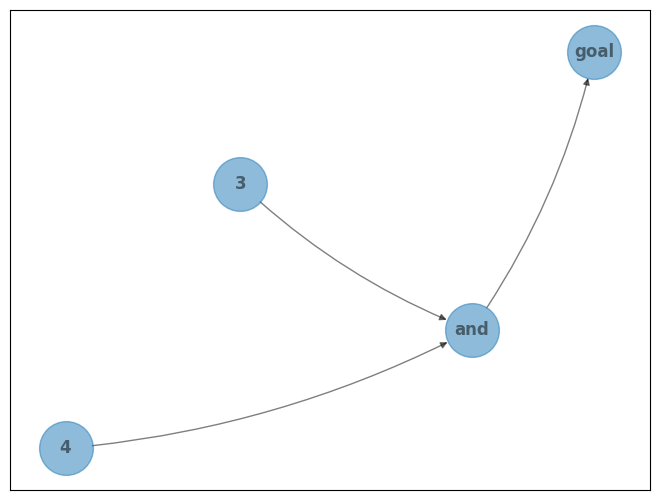

27


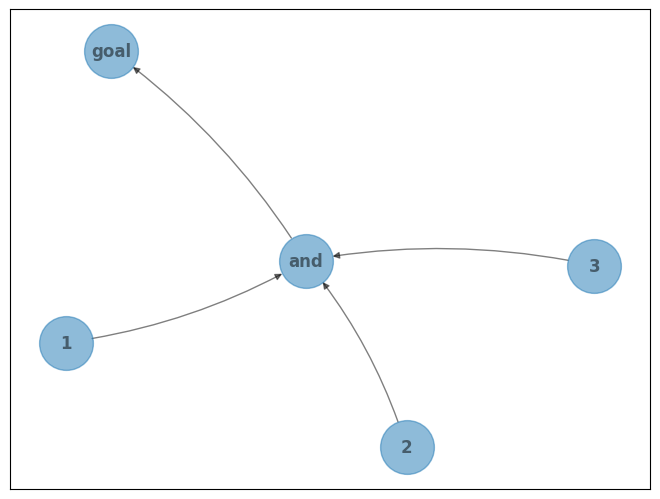

28


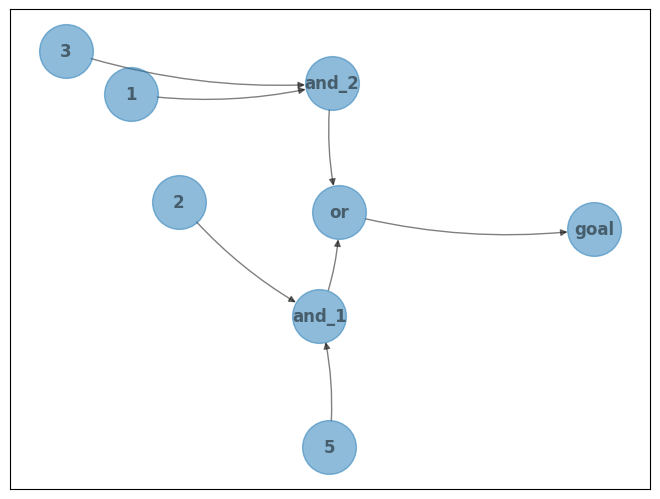

29


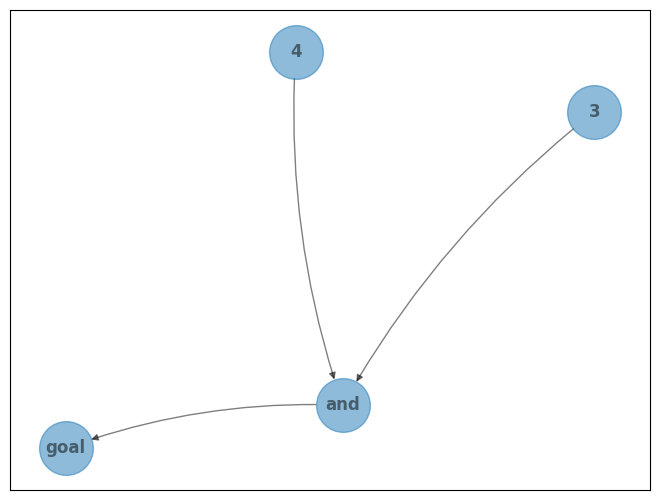

In [26]:
for i in range(len(G_dict)):
    nx.draw(G_dict[i], with_labels=True,
        node_size=1500, alpha=0.5, font_weight="bold", arrows=True,
        connectionstyle='arc3, rad = 0.1')
    print(i)
    plt.axis('on')
    plt.show()